<a href="https://colab.research.google.com/github/spetryk/ai4all2020/blob/master/1-MRIGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Training a GAN on Brain MRI Images

Hello! In this notebook we'll train a GAN to generate fake MRI brain scans. We'll set up the dataset and neural networks, then train the GAN and see how the output changes over time.


In [ ]:
## For Google CoLab to set everything up
! git clone https://github.com/spetryk/ai4all2020.git
! pip install nilearn
%cd ai4all2020/
! wget https://ai4all-2020.s3.amazonaws.com/data/mris.pt
%mkdir mridata
%mv mris.pt mridata

In [1]:
%matplotlib inline

# Functions for training neural network
from mri_tools import Generator, Discriminator, get_brainomics_dataloader, update, gradient_penalty, save_model
import torch
import torch.optim as optim
import os


# Functions for visualizations
import torchvision
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.animation import PillowWriter

# from https://stackoverflow.com/questions/51512141/how-to-make-matplotlib-saved-gif-looping
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)


## Data


To train a GAN, we need to keep giving it examples of what real images should look like. Right now, we have a folder with all of these images. How do we go from images saved as files on our computer to images in number-form that are ready for a neural network to use?

Fortunately, the machine learning framework that we are using called PyTorch can do this for us. We've placed most of the PyTorch code for this in the file **tools.py** and **dataloaders.py**, but this is what it's doing behind the scenes:

1. Reads each image file into a list of numbers that specify the color at each pixel
2. Processes each image to the correct size and range of values
3. Creates a **data loader**, which keeps track of which images the GAN used already so it can keep giving it new ones in each round of training

The code below creates the data loader and plots some sample images.


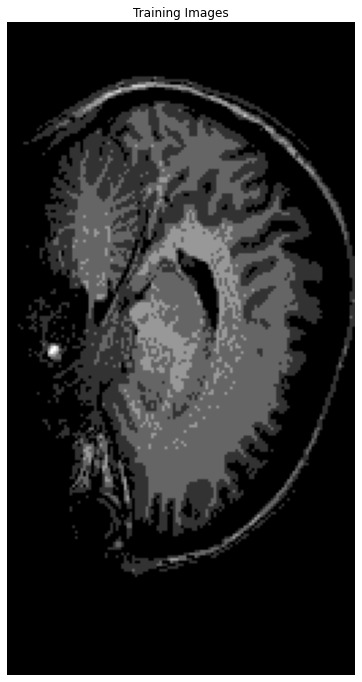

In [2]:
# Folder where images are stored
dataroot = "./mridata"

# Batch size: number of images the GAN sees in one round of training
batch_size = 64

dataloader = get_brainomics_dataloader(dataroot, batch_size)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Input to the generator

Remember that the input to the generator model is just a random bunch of numbers.
Let's see what that looks like - it'll help you appreciate how difficult this problem is!

Note: The actual input is 1-dimensional - just a list of numbers. We'll create noise in the shape of a square just for visualization. The function we will use is [here](https://pytorch.org/docs/master/generated/torch.randn.html)

In [4]:
noise = # TODO fill in, using the torch.randn function
plt.imshow(noise, cmap='gray')
plt.title('Example of noise')
plt.show()

SyntaxError: invalid syntax (<ipython-input-4-1697984fec83>, line 1)

## Creating the models


Let's now create the generator and discriminator models. If you would like to, you can look at the network structure defined in the **tools.py** file and change the model. You can also change the training settings in the next cell.

In [3]:
# Size of noise vector (i.e. size of generator input)
noise_size = 100

# Use a GPU if available, or you can choose to use the CPU by setting use_cpu = True
use_cpu = False
device = 'cuda:0' if (torch.cuda.is_available() and not use_cpu) else 'cpu'
print('Using device {}\n'.format(device))

img_size = (240, 128, 1)
generator     = Generator(img_size=img_size, latent_dim=noise_size).to(device)
discriminator = Discriminator(img_size=img_size).to(device)

# Initialize the weights of the networks
#generator.apply(initialize_weights)
#discriminator.apply(initialize_weights)

# Print out the network structure
print('Generator structure:')
print(generator)
print('\n')

print('Discriminator structure:')
print(discriminator)

Using device cuda:0

Generator structure:
Generator(
  (latent_to_features): Sequential(
    (0): Linear(in_features=100, out_features=15360, bias=True)
    (1): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)


Discriminator structure:
Discriminator(
  (image_to_features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4,

## Training the GAN


In [9]:
# Training settings
number_of_epochs = 20
learning_rate    = 0.0001

# Create optimizers, which are functions that will update the models for us
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.9, 0.99))
generator_optimizer     = optim.Adam(generator.parameters(),     lr=learning_rate, betas=(0.9, 0.99))

# Create batch of noise that we will use to visualize
# the progression of the generator
shape = (64, noise_size)
fixed_noise = torch.randn(shape, device=device)

# Create folder to save models in case training is interrupted
save_dir = './mri_saved_models'
os.makedirs(save_dir, exist_ok=True)


# Exercise 1
Write functions to calculate losses for the discriminator and generator. A loss function indicates how poorly the generator or discriminator is doing. So a high loss value for the generator means that it is doing a poor job fooling the discriminator, and a high loss value for the discriminator means that it is not guessing which images are real or fake correctly.
## Discriminator Loss
The discriminator should get credit for predicting "real" (i.e. predicting 1) on real images, and for predicting "fake" (i.e. predicting 0) on fake images. To make this calculation, we first need to see what the discriminator predicts on the real images, and then see what the discriminator predicts on the fake images. We use these predictions to compute the loss for each, and then we sum up the two losses.
## Generator Loss
The generator should get credit when the discriminator predicts "real" (i.e. predicts 1) on an image that the generator predicted. To figure this out, we need to see what the discriminator predicts on the generator-produced images, and then we use that prediction to compute the loss.
## Useful Functions
To generate fake images with the generator, you can simply call the generator as a function, passing in the input noise:
```
generated_images = generator(noise)
```
To predict whether an images are real or fake using the discriminator, you can do something similar:
```
predictions = discriminator(images)
```
To calculate the loss function, you can use a function called `calculate_loss`, which takes the discriminator's predictions, as well as the ground truth labels. For example, if the discriminator predicts `[0.2, 0.8, 0.9]` for three real images, you could compute the discriminator's loss by running
```
loss = calculate_loss([0.2, 0.8, 0.9], [1, 1, 1])
```
To figure out how to compute the correct loss values, keep in mind that `calculate_loss` will return a small value (i.e. the model is doing well) if the predictions and the true labels match.

In [ ]:
# Training Loop

# Lists to keep track of progress
sample_generator_images = []
G_losses = []
D_losses = []

# Keep track of discriminator performance
probs_real = []
probs_fake = []

iters = 0

print("Starting Training Loop...")

# For each epoch
for epoch in range(number_of_epochs):
    print('****** Starting epoch {} ******'.format(epoch))
    
    # For each batch in the dataloader
    for iteration, data in tqdm(enumerate(dataloader), total=len(dataloader)):
    
        # Parse data into the correct format for training
        real_images = data.cuda()
        noise = torch.randn(real_images.size(0), noise_size, device="cuda")

        ############################
        # (1) Update Discriminator
        ###########################
        discriminator.zero_grad()
        
        # Train discriminator on all-real batch
        predictions_on_real = discriminator(real_images)
        loss_on_real = 1 - predictions_on_real.mean()
        
        # Train discriminator on all-fake batch
        fake_images         = generator(noise)
        predictions_on_fake = discriminator(fake_images.detach())
        loss_on_fake = predictions_on_fake.mean()
        
        extra_loss = gradient_penalty(discriminator, real_images, fake_images.detach())
        
        # Update the discriminator model
        discriminator_loss = loss_on_real + loss_on_fake + extra_loss
        update(discriminator_optimizer, discriminator_loss)
        

        ############################
        # (2) Update Generator
        ###########################
        generator.zero_grad()
        
        # Try to fool discriminator into predicting that fake images are real
        predictions_on_fake = discriminator(fake_images)
        generator_loss      = -1 * predictions_on_fake.mean()
        update(generator_optimizer, generator_loss)
        
        # Output training stats every 100 iterations
        if iteration % 100 == 0:
            print('Iteration %d.\tLoss_D: %.4f\tLoss_G: %.4f\tProb real: %.4f\tProb fake: %.4f'
                  % (iteration,
                     discriminator_loss.item(),
                     generator_loss.item(),
                     predictions_on_real.mean().item(),
                     1 - predictions_on_fake.mean().item()))
            
        # Save Losses for plotting later
        G_losses.append(generator_loss.item())
        D_losses.append(discriminator_loss.item())
        probs_real.append(predictions_on_real.mean().item())
        probs_fake.append(1 - predictions_on_fake.mean().item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == number_of_epochs-1) and (iteration == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            samples = vutils.make_grid(fake, padding=2, normalize=True)
            sample_generator_images.append(samples)
            
        iters += 1
        
        
    # Save models in case training is interrupted
    print('Saving models to {}'.format(save_dir))
    save_model(discriminator, discriminator_optimizer, epoch, os.path.join(save_dir, 'discriminator_epoch{}'.format(epoch)))
    save_model(generator,     generator_optimizer,     epoch, os.path.join(save_dir, 'generator_epoch{}'.format(epoch)))

    
    # Show some sample generated images after each epoch
    fig = plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(np.transpose(sample_generator_images[-1], (1,2,0)))
    plt.show()

Starting Training Loop...
****** Starting epoch 0 ******


Iteration 0.	Loss_D: 1.4686	Loss_G: -0.2541	Prob real: 0.8330	Prob fake: 0.7459
Iteration 100.	Loss_D: 0.9640	Loss_G: -0.5005	Prob real: 0.8142	Prob fake: 0.4995


AttributeError: 'LoopingPillowWriter' object has no attribute '_outfile'

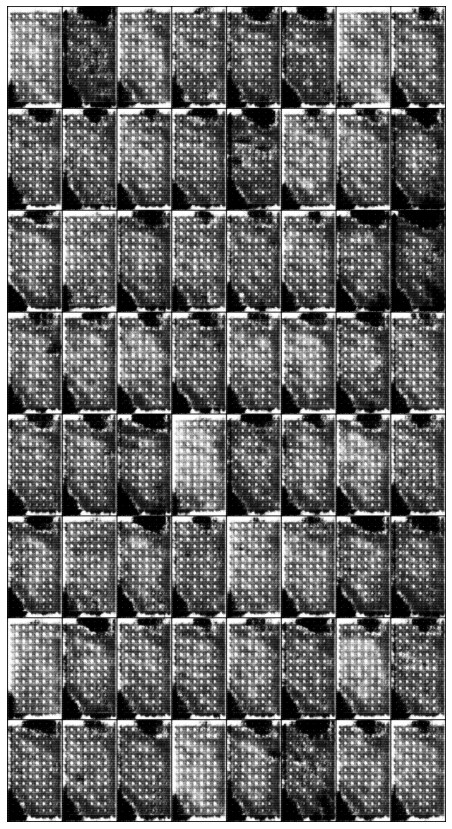

In [6]:
# Plot
fig = plt.figure(figsize=(15,15))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in sample_generator_images]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

ani.save('training.gif', writer=LoopingPillowWriter(fps=20))

HTML(ani.to_jshtml())

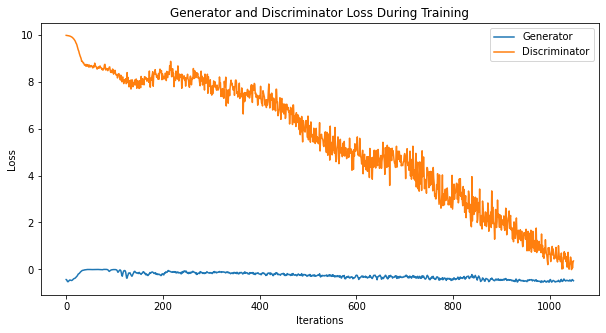

In [7]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

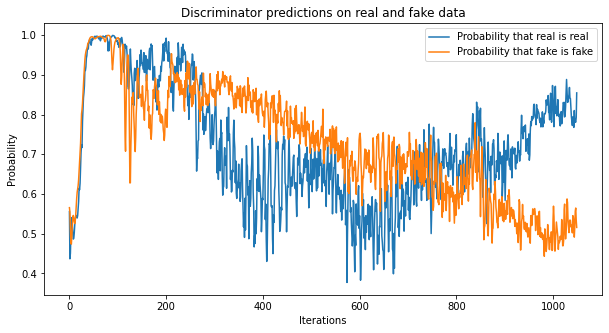

In [8]:
plt.figure(figsize=(10,5))
plt.title("Discriminator predictions on real and fake data")
plt.plot(probs_real,label="Probability that real is real")
plt.plot(probs_fake,label="Probability that fake is fake")
plt.xlabel("Iterations")
plt.ylabel("Probability")
plt.legend()
plt.show()

# Bonus: Exercise 2
Sometimes, the discriminator has a harder time detecting fake images than the generator does creating fake images. When this happens, the generator can "win", and then learning stops. To address this, one common practice is to update the discriminator several times between each time that you update the generator.
Implement this feature in the above training loop, allowing for a variable number of discriminator steps between each generator step depending on a variable `DISCRIMINATOR_STEPS_PER_GENERATOR_STEP`.